In [1]:
# pip install networkx
# pip install schemdraw
# openpyxl

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
# import schemdraw
# from schemdraw import flow
# import schemdraw.elements as elm
import numpy as np
# import networkx as nx
import datetime as dt
from matplotlib.lines import Line2D

In [10]:
df = pd.read_excel('arbeitspakete_phase_2.xlsx')
df

,Nr,Vorgangsname,Dauer,Vorgaenger
0,1,Kick-Off Meeting,1,0
1,2,Rechtsberatung,2,1
2,3,Design & Struktur,2,2
3,4,Vorstellung Detailkonzept,0,3
4,5,Überprüfung und Anpassung,2,4
5,6,Fotos,5,5
6,7,Videos,10,5
7,8,360° Fotos,15,5
8,9,Texte,4,5
9,10,Übersetzungen,8,9


In [11]:

def prepare_df(excel_file_name):

    # daten aus excel tabelle einlesen
    df = pd.read_excel(excel_file_name)
    
    dfc = df.copy()

    # replace NaN with zero
    dfc.fillna(0, inplace=True)

    # in spalte "Vorgaenger" die (;-separated) strings in integer-lists umwandeln
    dfc["Vorgaenger"] = [ [int(i) for i in j.split(";")] if (type(j) == str) else [j] for j in dfc.Vorgaenger ]

    # spalte "Nachfolger" hinzufügen
    temp = [ [0] for i in dfc.index ]
    for i in dfc.index:
        if dfc.Vorgaenger[i][0]:
            for V in dfc.Vorgaenger[i]:
                if temp[V-1][0]:
                    temp[V-1].append(i+1)
                else:
                    temp[V-1] = [i+1]
    dfc["Nachfolger"] = temp
    
    # FAZ und FEZ spaltenwerte berechnen (früheste anfangs/end-zeit)
    temp = []
    for i in dfc.index:
        if dfc.Vorgaenger[i][0]:
            temp.append( max( [temp[V-1]+dfc.Dauer[V-1] for V in dfc.Vorgaenger[i]] ) )
        else:
            temp.append(0)
    dfc["FAZ"] = temp
    dfc["FEZ"] = dfc["FAZ"] + dfc.Dauer
    
    # SEZ und SAZ spaltenwerte berechnen (späteste anfangs/end-zeit)
    dfc["SAZ"] = dfc["FEZ"].max()
    dfc["SEZ"] = dfc["SAZ"]
    for i in dfc.index[::-1]:
        if not dfc.Nachfolger[i][0]:
            dfc.loc[i,'SAZ'] = dfc.SEZ[i] - dfc.Dauer[i]
        if dfc.Vorgaenger[i][0]:
            for j in dfc.Vorgaenger[i]:
                if dfc.SEZ[j-1] > dfc.SAZ[i]:
                    dfc.loc[j-1,'SEZ'] = dfc.SAZ[i]
                dfc.loc[j-1,'SAZ'] = dfc.SEZ[j-1] - dfc.Dauer[j-1]
                
    #  add column GS = Gesamtpuffer
    dfc["GP"] = dfc.SAZ - dfc.FAZ

    #  add column FS = freier Puffer
    temp = []
    for i in dfc.index:
        if dfc.Nachfolger[i][0]:
            temp.append(min([dfc.FAZ[V-1] for V in dfc.Nachfolger[i]]) - dfc.FEZ[i])
        else:
            temp.append(0)
    dfc["FP"] = temp
    
    # add column "plot_index"
    dfc["plot_index"] = dfc.index[::-1]
    
    return dfc


In [12]:
dfc = prepare_df('arbeitspakete_phase_2.xlsx')
dfc

,Nr,Vorgangsname,Dauer,Vorgaenger,Nachfolger,FAZ,FEZ,SAZ,SEZ,GP,FP,plot_index
0,1,Kick-Off Meeting,1,[0],[2],0,1,0,1,0,0,34
1,2,Rechtsberatung,2,[1],[3],1,3,1,3,0,0,33
2,3,Design & Struktur,2,[2],[4],3,5,3,5,0,0,32
3,4,Vorstellung Detailkonzept,0,[3],[5],5,5,5,5,0,0,31
4,5,Überprüfung und Anpassung,2,[4],"[6, 7, 8, 9, 11, 14, 15, 16, 18, 19, 20, 21, 2...",5,7,5,7,0,0,30
5,6,Fotos,5,[5],"[12, 28]",7,12,17,22,10,10,29
6,7,Videos,10,[5],"[12, 28]",7,17,12,22,5,5,28
7,8,360° Fotos,15,[5],"[12, 28]",7,22,7,22,0,0,27
8,9,Texte,4,[5],"[10, 28]",7,11,10,14,3,0,26
9,10,Übersetzungen,8,[9],"[12, 13, 28]",11,19,14,22,3,0,25


In [13]:
def plot_hbars_classic(dfc, title, start_date = 0):
    
    num_xticks = dfc.SEZ.max()
    
    plt.figure(figsize=(max([len(i) for i in dfc.Vorgangsname])//10 + dfc.SEZ.max()//4, dfc.index.size//2))
    plt.xlabel('Tage', size=25)
    plt.ylabel('Vorgangsliste', size=25)
    plt.title(title, size=25)
    
    dates = []
    
    if start_date:
        if type(start_date) == str:
            start_date = dt.datetime( *map(int, start_date.split("-")) )
        elif type(start_date) == list:
            start_date = dt.datetime( *map(int, start_date) )
            
        dates = [ start_date + dt.timedelta(days=i) for i in range(num_xticks) ]
        x_labels = [ f'{i+1}:  {date.strftime("%b - %d")}' for i, date in enumerate(dates) ]
        plt.xticks(np.arange(num_xticks), labels=x_labels, rotation = 70, size=15)
        plt.bar(
            np.arange(num_xticks),
            [dfc.index.size if date.strftime("%a") in {"Sat", "Sun"} else 0 for date in dates],
            1,
            align="edge",
            color="k",
            alpha=.08
        )
    
    else:
        plt.xticks(np.arange(num_xticks+1), size=13)
    
    y_labels = [dfc.Vorgangsname[i] + f" - {dfc.Nr[i]}" for i in dfc.index]

    plt.yticks(ticks=dfc.plot_index, labels=y_labels, size=16)

    plt.barh(dfc.plot_index, dfc.Dauer, .9, align="center", left=dfc.FAZ, color="blue")

    milestones = dfc[dfc.Dauer == 0]
    plt.scatter( milestones.FAZ, milestones.plot_index, c="blue", s=400, marker="d" )
    plt.grid()

    plt.show()

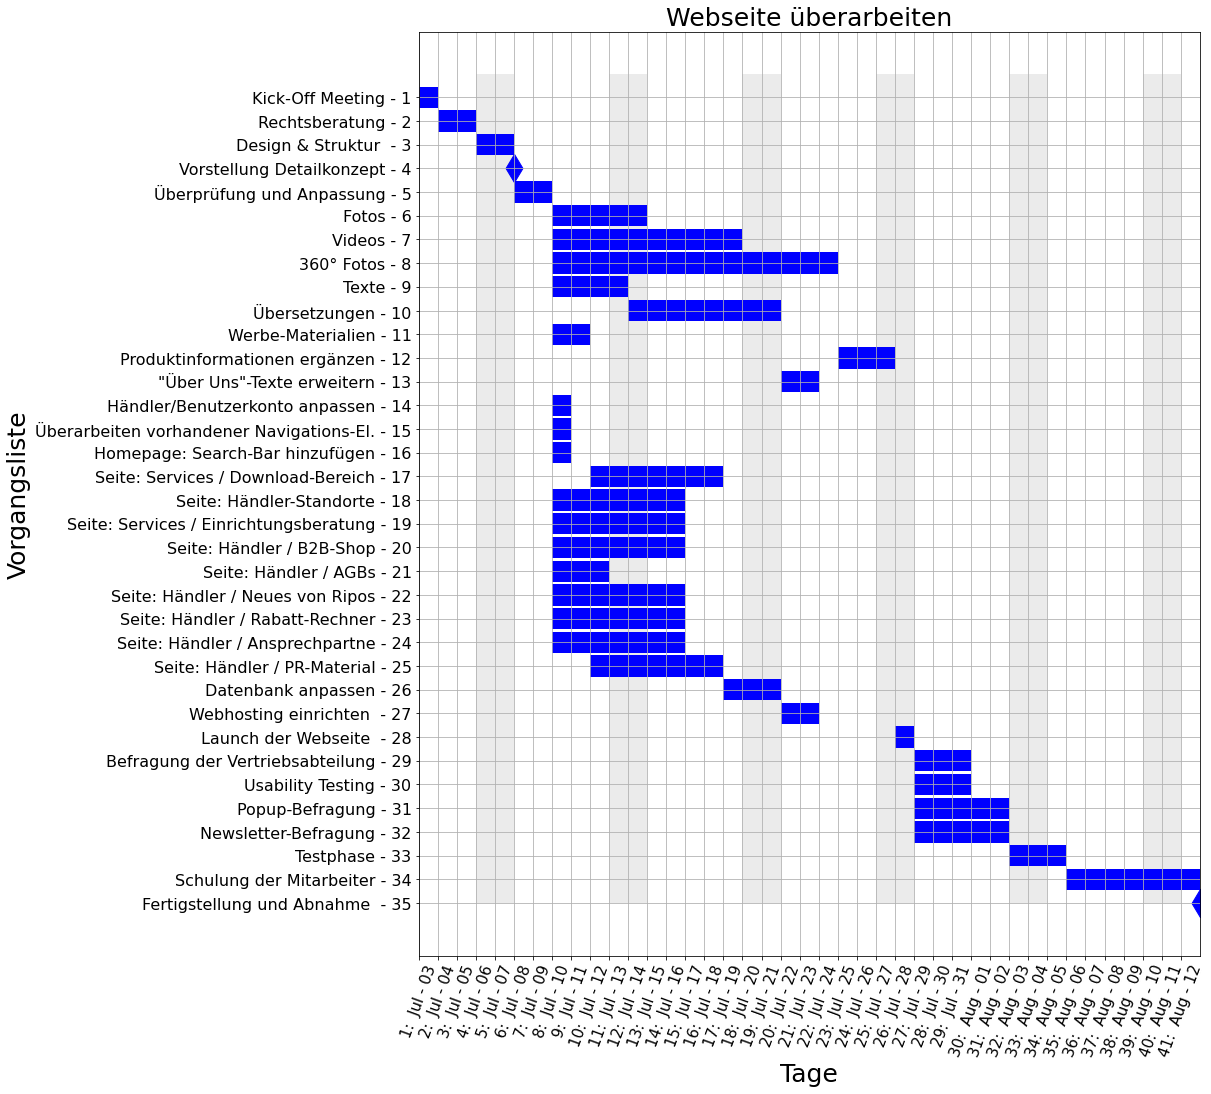

In [17]:
plot_hbars_classic(dfc, "Webseite überarbeiten", "2024-07-03")

In [15]:
def plot_hbars_new(dfc, title, start_date = 0):
    
    num_xticks = dfc.SEZ.max()
    
    plt.figure(figsize=(max([len(i) for i in dfc.Vorgangsname])//10 + dfc.SEZ.max()//4, dfc.index.size//2))
    plt.xlabel('Tage', size=25)
    plt.ylabel('Arbeitsschritte', size=25)
    plt.title(title, size=25)
    
    dates = []
    
    if start_date:
        if type(start_date) == str:
            start_date = dt.datetime( *map(int, start_date.split("-")) )
        elif type(start_date) == list:
            start_date = dt.datetime( *map(int, start_date) )
            
        dates = [ start_date + dt.timedelta(days=i) for i in range(num_xticks) ]
        x_labels = [ f'{i+1}:  {date.strftime("%b - %d")}' for i, date in enumerate(dates) ]
        plt.xticks(np.arange(num_xticks), labels=x_labels, rotation = 70, size=15)
        plt.bar(
            np.arange(num_xticks),
            [dfc.index.size if date.strftime("%a") in {"Sat", "Sun"} else 0 for date in dates],
            1,
            align="edge",
            color="k",
            alpha=.08
        )
    
    else:
        plt.xticks(np.arange(num_xticks+1), size=13)
    
    y_labels = [dfc.Vorgangsname[i] + f" - {dfc.Nr[i]}" for i in dfc.index]

    plt.yticks(ticks=dfc.plot_index, labels=y_labels, size=16)

    plt.barh(dfc.plot_index, dfc.SEZ - dfc.FAZ, .8, align="center", left=dfc.FAZ, color="lightgreen")
    plt.barh(dfc.plot_index, [FP+dfc.Dauer[i] if FP else 0 for i, FP in enumerate(dfc.FP)], .8, align="center", left=dfc.FAZ, color="tab:orange")
    plt.barh(dfc.plot_index, dfc.Dauer, -.4, align="edge", left=dfc.FAZ, color="blue")
    plt.barh(dfc.plot_index, dfc.Dauer, .4, align="edge", left=dfc.SAZ, color="blue")

    milestones = dfc[dfc.Dauer == 0]
    plt.scatter( milestones.FAZ, milestones.plot_index, c="red", s=400, marker="d" )
    plt.scatter( milestones.SEZ, milestones.plot_index, c="red", s=400, marker="d" )
    plt.grid()
    
    custom_lines = [Line2D([0], [0], color='lightgreen', lw=8 ),
                Line2D([0], [0], color='tab:orange', lw=8 )]
    plt.legend(custom_lines, ['GP', 'FP'], loc='upper right', fontsize=(dfc.SEZ.max()+40)//4 )

    plt.show()


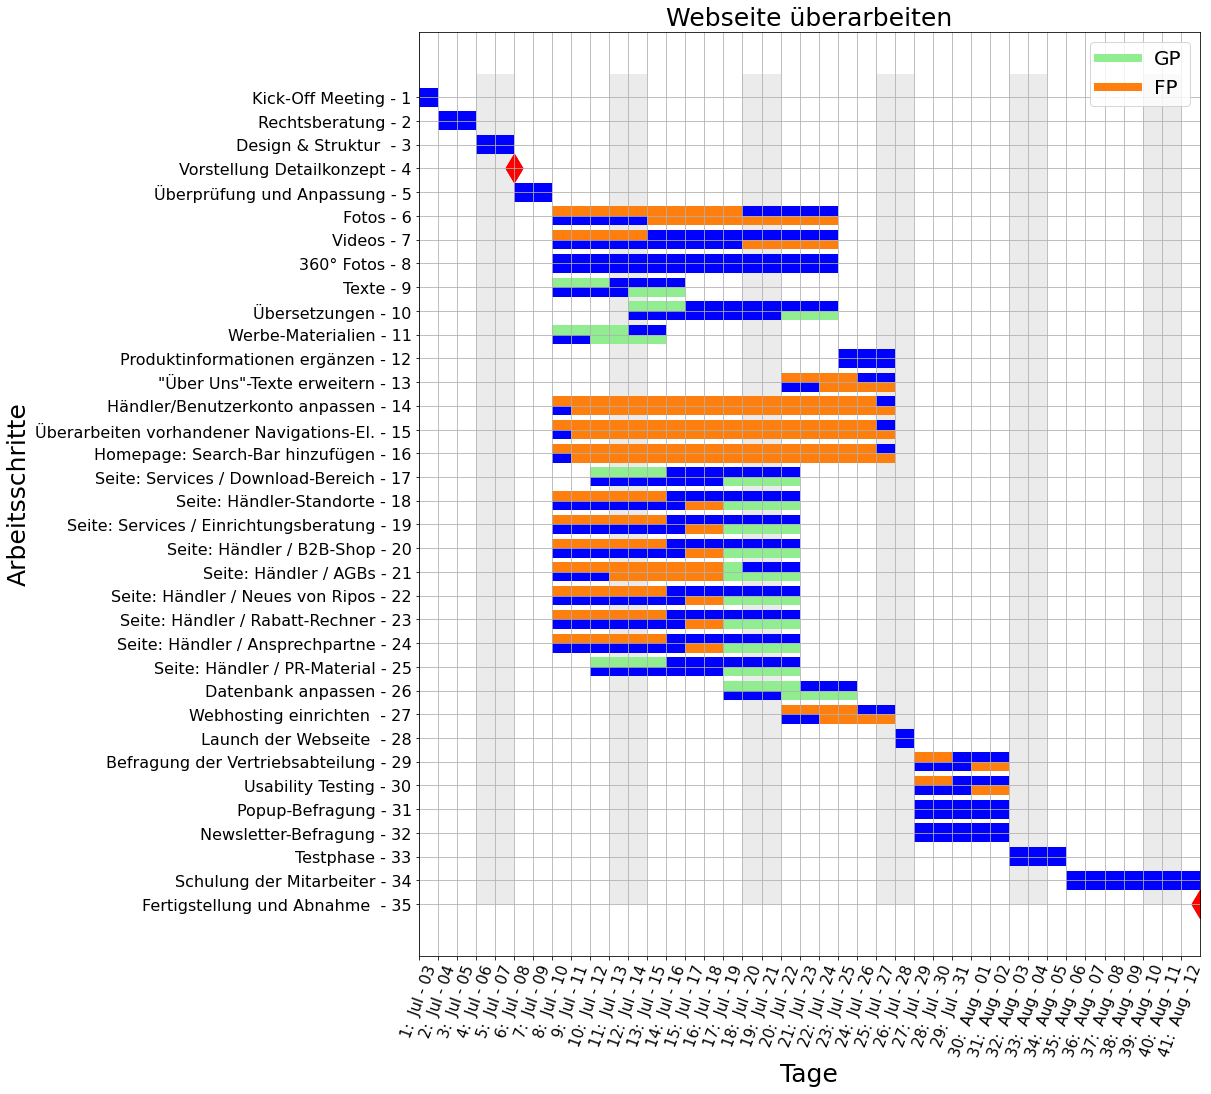

In [18]:
plot_hbars_new(dfc, "Webseite überarbeiten", "2024-07-03")